# Crane optimization
Here is some text explaining the problem at hand.

And maybe a figure.

And here is some math:
$$
e^{i \pi} + 1 = 0
$$

In [272]:
# Enable interactive plot
# %matplotlib notebook
%matplotlib inline

In [273]:
# Imports:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
import casadi as cs
plt.style.use('seaborn-pastel')

Explain dynamics briefly. Show the equations...

In [274]:
r = cs.SX.sym('r')
theta = cs.SX.sym('theta')
r_dot = cs.SX.sym('r_dot')
theta_dot = cs.SX.sym('theta_dot')
x = cs.vertcat(r, theta, r_dot, theta_dot)

u = cs.SX.sym('F')

m_1 = 5.0  # mass of cart
m_2 = 1.0  # mass of pendulum
l = 1.0    # length of pendulum
g = 9.81   # gravity

M_inv = cs.SX(2,2)
M_inv[0,0] = m_2 * l**2
M_inv[0,1] = - m_2 * l * cs.cos(theta)
M_inv[1,0] = - m_2 * l * cs.cos(theta)
M_inv[1,1] = m_1 + m_2
M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

h = cs.SX(2,1)
h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
h[1,0] = m_2 * l * g * cs.sin(theta)

x_dot = cs.vertcat(x[2:], cs.mtimes(M_inv, (cs.vertcat(u, 0) - h)))
f = cs.Function('f', [x, u], [x_dot])

Explain discretization briefly? RK4

In [275]:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

dt = 0.04
x_0 = np.array([-0.5, 0.0, 0.0, 0.0])
r_0 = 0.5

f_d = cs.Function('f', [x, u], [integrate_RK4(x, u, f, dt)])

Optimization:
Need to show problem we are formulating and explain NLPs briefly

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

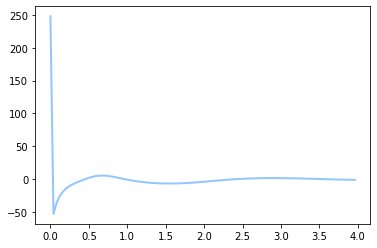

In [276]:
# Number of control segments
N = 100

# Objective function and constraints
J_k = cs.Function('J_k', [x, u], [1000*(r - r_0)**2 + 1000*theta**2 + 100*r_dot**2 + 100*theta_dot**2 + 0*2*u**2])

# Start with an empty NLP
w = []
w0 = [] # TODO set one single time instead
lbw = []
ubw = []
J = 0
g = []
lbg = []
ubg = []

# Formulate the NLP
X_k = cs.MX(x_0)
for k in range(N):
    # New NLP variable for the control
    # U_k = cs.MX.sym('U_' + str(k), 2)
    U_k = cs.MX.sym('U_' + str(k))
    w += [U_k]
    # lbw += [-100, -100]
    # ubw += [100, 100]
    # w0 += [0, 0]
    lbw += [-1000]
    ubw += [1000]
    w0 += [0]

    # Integrate till the end of the interval
    X_k = f_d(X_k, U_k)
    J += dt * J_k(X_k, U_k)

    # Add inequality constraint
    # g += [X_k[1]]
    # lbg += [-0.25]
    # ubg += [0.25]

# Create an NLP solver
nlp = {'f': J, 'x': cs.vertcat(*w)}#, 'g': cs.vertcat(*g)}
solver = cs.nlpsol('solver', 'ipopt', nlp)

# Solve the NLP
sol = solver(x0=w0, lbx=lbw, ubx=ubw)#, lbg=lbg, ubg=ubg)
u_sol = sol['x']

t = np.array([dt*i for i in range(N)])
plt.figure()
plt.plot(t, u_sol)
plt.show()

Simulation:

In [277]:
N_sim = 1000
dt_sim = 0.005
k_u = int(dt/dt_sim)
x_sim = np.zeros((N_sim+1,4))
x_sim[0,:] = x_0
u_sim = np.zeros(N_sim)
for k in range(N_sim):
    if k < k_u * N: u_sim[k] = u_sol[int(k/k_u)]
    x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()

Plots:

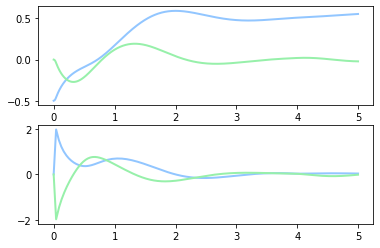

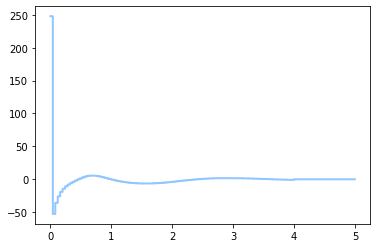

In [278]:
t = np.array([dt_sim*i for i in range(N_sim)])

fig, ax = plt.subplots(2)

ax[0].plot(t, x_sim[:N_sim,0])
ax[0].plot(t, x_sim[:N_sim,1])

ax[1].plot(t, x_sim[:N_sim,2])
ax[1].plot(t, x_sim[:N_sim,3])

plt.figure()
plt.step(t, u_sim, where='post')

plt.show()

Animation:

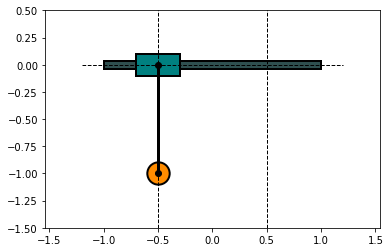

In [279]:
from IPython.display import HTML

mpl.rcParams['lines.linewidth'] = 2

skips = 10
frames = int(N_sim / skips)
delay = skips*dt_sim*1e3

rect_height = 0.2
beam_height = 0.075

fig, ax = plt.subplots()

line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', lw=1.0)
rect_1 = ax.add_patch(Rectangle((0 - 1, 0 - 0.5*beam_height), 2, beam_height, facecolor='darkslategray', edgecolor='k', lw=2))
rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.0 - 0.5*rect_height), 0.4, rect_height, facecolor='teal', edgecolor='k', lw=2))

x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
y_pendulum = -l * np.cos(x_sim[0,1])
line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
point_1 = ax.scatter(x_pendulum, y_pendulum, s=500, facecolors='darkorange', edgecolors='k', lw=2)

line_3, = ax.plot([-0.5, -0.5], [-1.5,0.5], 'k--', lw=1.0)
line_3, = ax.plot([0.5, 0.5], [-1.5,0.5], 'k--', lw=1.0)

plt.axis('equal')
plt.xlim([-1, 1])
plt.ylim([-1.5, 0.5])

def animate(i):
    rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
    
    x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
    y_pendulum = -l * np.cos(x_sim[skips*i,1])
    
    point_1.set_offsets([x_pendulum, y_pendulum])
    line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
    
    return line_2, point_1, rect_2

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

We can run this to show the animation in HTML afterwards (press play button):

In [280]:
HTML(anim.to_jshtml())

Unfortunately the animation is quite slow when run in real-time... So not quite sure what to do about that...